# Accessing GEDI L4A variables using NASA Harmony API

[NASA's Harmony Services](https://harmony.earthdata.nasa.gov/) allows seamless access and production of  analysis-ready Earth observation data across different DAACs, by enabling cloud-based spatial, temporal, and variable subsetting and data conversions.  The [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) is available from NASA Harmony API. 

This tutorial demonstrates how to directly access and subset the GEDI L4A variables using Harmony API for an area in [NASA's Delta-X project](https://deltax.jpl.nasa.gov/). The Delta-X project collects [field and airborne measurements](https://daac.ornl.gov/cgi-bin/dataset_lister.pl?p=41) of ecological and hydrology variables over the two river basins (Atchafalaya and Terrebonne) in the Mississippi River Delta of the United States. The subset of the GEDI L4A dataset for the Delta-X area can enable a comparison of aboveground biomass between GEDI L4A and the field measurements.

While NASA's Harmony services are available directly through RESTful API, we will use [Harmony-Py](https://github.com/nasa/harmony-py) Python library for this tutorial. Harmony-Py provides a friendly interface for integrating with NASA's Harmony Services. In addition to Harmony-Py, this tutorial requires the following Python modules installed in your system: `h5py`, `requests`, `datetime`, `pandas`, `geopandas`, `contextily`. Requirements are also in [requirements.txt](requirements.txt). To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
pip install -r requirements.txt
```

In [1]:
# import python modules
%matplotlib inline
import h5py
import requests as re
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from datetime import datetime
from glob import glob
from harmony import BBox, Client, Collection, Environment, Request

NASA Harmony API requires [NASA Earthdata Login (EDL)](https://urs.earthdata.nasa.gov/). You can set up NASA Earthdata Login authentication using a `.netrc` file. Please refer to the instructions here: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget. Alternatively, you can also login to harmony_client directly by passing EDL authentication as the following in the Jupyter Notebook itself:

```
harmony_client = Client(auth=("your EDL username", "your EDL password"))
```

First, we create a Harmony Client object. If you are passing the EDL authentication, please do as shown above with `auth` parameter.

In [2]:
harmony_client = Client()

Now let's retrieve the `Concept ID` of the GEDI L4A dataset. The `Concept ID` is NASA Earthdata's unique ID for its dataset. 

In [3]:
# GEDI L4A DOI 
doi = '10.3334/ORNLDAAC/2056'

# CMR API base url
doisearch=f'https://cmr.earthdata.nasa.gov/search/collections.json?doi={doi}' 
concept_id = re.get(doisearch).json()['feed']['entry'][0]['id']
concept_id

'C2237824918-ORNL_CLOUD'

Let's create a Harmony Collection object with the concept_id retrieved above. We will also define the GEDI L4A variables of interest and temporal range.

In [4]:
collection = Collection(id=concept_id)
variables = ['/BEAM0101/agbd', 
             '/BEAM0101/l4_quality_flag', 
             '/BEAM0101/shot_number',
             '/BEAM0101/delta_time', 
             '/BEAM0101/lat_lowestmode', 
             '/BEAM0101/lon_lowestmode']
temporal_range = {'start': datetime(2019, 4, 1), 
                  'stop': datetime(2020, 5, 31)}

We will use the spatial extent of a [Pre-DeltaX Vegetation Structure dataset](https://doi.org/10.3334/ORNLDAAC/1805). The location and aboveground biomass  of the *Salix nigra* plots collected in the Spring of 2015 are provided as a GeoJSON file at `/polygons/atchafalaya_salix_spring15.json`. Let's open this file and compute its bound.

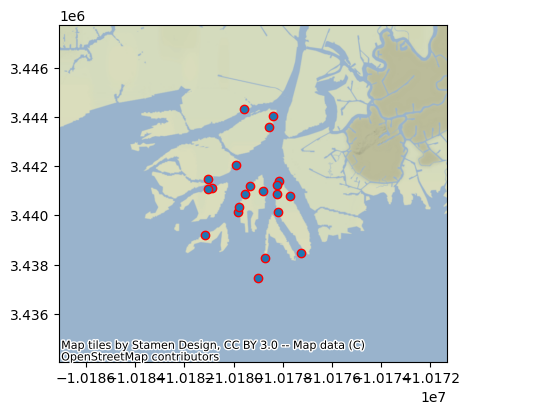

In [5]:
salix = gpd.read_file("polygons/atchafalaya_salix_spring15.json") 
b = salix.total_bounds
# bounding box for Harmony
bounding_box = BBox(w=b[0], s=b[1], e=b[2], n=b[3])
# map of Salix plots
ax=salix.to_crs(epsg=3857).plot(figsize=(5, 5), edgecolor='red')
plt.margins(y=0.5, x=1.5)
ctx.add_basemap(ax, zoom = 13)

Now we can create a Harmony request with variables, temporal range, and bounding box and submit the request using the Harmony client object. We will use the `download_all` method, which uses a multithreaded downloader and returns a [concurrent future](https://docs.python.org/3/library/concurrent.futures.html). Futures are asynchronous and let us use the downloaded file as soon as the download is complete while other files are still being downloaded. 

In [6]:
request = Request(collection=collection, 
                  variables=variables, 
                  temporal=temporal_range,
                  spatial=bounding_box)

# submit harmony request, will return job id
subset_job_id = harmony_client.submit(request)

print(f'Processing job: {subset_job_id}')

print(f'Waiting for the job to finish')
results = harmony_client.result_json(subset_job_id, show_progress=True)

print(f'Downloading subset files...')
futures = harmony_client.download_all(subset_job_id, overwrite=False)
for f in futures:
    # all subsetted files have this suffix
    if f.result().endswith('subsetted.h5'):
        print(f'Downloaded: {f.result()}')
            
print(f'Done downloading files.')

Processing job: b28d92b8-8754-4613-a153-a374e13bf6ad
Waiting for the job to finish


 [ Processing: 100% ] |###################################################| [|]


GEDI04_A_2019148212155_O02594_02_T04606_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2019148212155_O02594_02_T04606_02_002_02_V002_subsetted.h5
GEDI04_A_2019200010439_O03388_02_T00337_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2019200010439_O03388_02_T00337_02_002_02_V002_subsetted.h5
GEDI04_A_2020102150820_O07538_02_T04606_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2020102150820_O07538_02_T04606_02_002_02_V002_subsetted.h5
GEDI04_A_2020126054750_O07904_02_T00337_02_002_02_V002_subsetted.h5
Downloaded: GEDI04_A_2020126054750_O07904_02_T00337_02_002_02_V002_subsetted.h5
Done downloading files.


All the subsetted files are saved as `_subsetted.h5`. Let's open these `h5` files and plot the `agbd` value in a map.

In [7]:
subset_df = pd.DataFrame()
for subfile in glob('*_subsetted.h5'):
    hf_in = h5py.File(subfile, 'r')
    beam = hf_in['BEAM0101']
    col_names = []
    col_val = []
    # read all variables
    for key, value in beam.items():
        col_names.append(key)
        col_val.append(value[:].tolist())

    # Appending to the subset_df dataframe
    beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names)
    subset_df = pd.concat([subset_df, beam_df])
    hf_in.close()
# print head of dataframe
subset_df.head()

,agbd,delta_time,l4_quality_flag,lat_lowestmode,lon_lowestmode,shot_number
0,10.014098,7.185488e+07,0,29.518411,-91.458868,75380500200240320
1,10.500650,7.185488e+07,0,29.518788,-91.458466,75380500200240321
2,11.524564,7.185488e+07,0,29.519165,-91.458064,75380500200240322
3,10.356710,7.185488e+07,0,29.519541,-91.457662,75380500200240323
4,10.417495,7.185488e+07,0,29.519918,-91.457260,75380500200240324


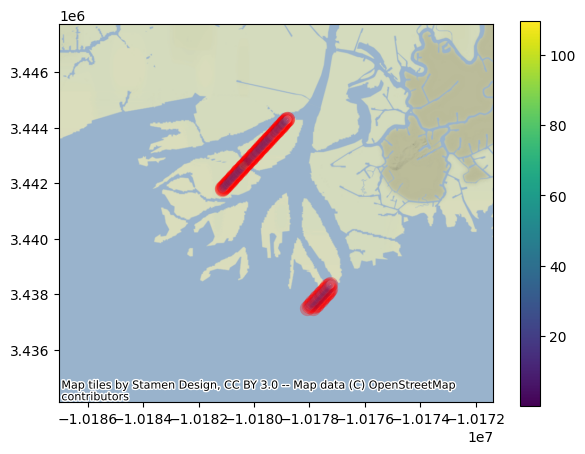

In [8]:
gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
gdf.crs="EPSG:4326"
gdf_epsg3857 = gdf.to_crs(epsg=3857)
ax1=gdf_epsg3857.plot(color='white', edgecolor='red', alpha=0.3, linewidth=5, figsize=(7, 5))
gdf_epsg3857[gdf_epsg3857['agbd'] != -9999][:-1].plot(ax=ax1, column='agbd', alpha=0.1, linewidth=0, legend=True)
plt.margins(y=0.5, x=1.5)
ctx.add_basemap(ax1, zoom=13)

Now that we have GEDI data downloaded, can you compare the aboveground estimates of GEDI L4B with that of the [Pre-DeltaX vegetation dataset](https://doi.org/10.3334/ORNLDAAC/1805)?

In the above steps, we used the Harmony services and retrieved the subsetted data directly to the local environment for further analysis without using the AWS cloud. The Harmony subsets data can also be directly accessed from the AWS `us-west-2` region if that is a preference.